## Identifying temp extremes 14day with climatology baseline
### CESM2 large ensemble data 2015-2100 (only 2015-2020 read in for testing)

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import numpy as np
import xarray as xr
from matplotlib import rcParams
import pandas as pd
from os import listdir
import matplotlib as mpl
import cftime
import glob
import math
import sys
import nc_time_axis
#import xcdat
import datetime

In [2]:
rcParams['font.size'] = 20

In [3]:
#define file locations
file_loc = '/div/no-backup/Large_Ensemble_data/CESM2-LENS'

#experiment name (ssp370 or ssp370-126aer)
exp_name = 'BSSP370smbb' #sys.argv[1] #'ssp370-126aer'

#change variable file label name, sets variable to read in
var_filelab = 'TREFHT'

#index variable name
var_name = 'TREFHTMX'

sigma_level = 2. #float(sys.argv[2]) #4.
sigma_lab = int(sigma_level)

lower_level = sigma_level -1
lower_sigma_lab = int(lower_level)

#output file location
output_write = '/div/nac/users/zofias/XXN/extreme_loc_tables'
out_plots = '/div/nac/users/zofias/plots/XXN'

In [4]:
# select region by changing region_label
region_label = 'NO' #sys.argv[3] #'EU' # 'SA' 'EA' 'NA' 'EU'

regions = {'SA': [5,35,65,95],
           'EA' : [20,53,95,133],
           'NA' : [25,70,-150,-45],
           'EU' : [35,70,-20,45],
           'NO' : [53,72,0,32]}

#selects lat lon bounds for region
lat_min, lat_max, lon_min, lon_max = regions[region_label]

In [5]:
var_filepath = f"{file_loc}/{exp_name}/{var_filelab}/daily"

In [6]:
#define filelist
filelist = sorted(glob.glob(f'{var_filepath}/*h1*.nc'))

# check filename label and adjust if incorrect
# should be e.g. 1011.001
#for file in filelist:
#    filelab = file.split('/')[-1][30:-34]
#    print(filelab)

#experiment labels from filelist
ens_labs = [file.split('/')[-1][30:-36] for file in filelist]

In [ ]:
#reads in daily PRECT for all ens members
ensemble_array = xr.open_mfdataset(filelist[:5], decode_times=True, combine="nested", concat_dim="member",data_vars=[var_name]).sel(time=slice('2015-01-01','2020-12-31'))

#make member coord labels correct
ensemble_array.coords['member'] = ens_labs[:5]

In [8]:
ensemble_array

<xarray.Dataset>
Dimensions:    (time: 2190, bnds: 2, lat: 192, lon: 288, member: 5)
Coordinates:
  * time       (time) object 2015-01-01 00:00:00 ... 2020-12-31 00:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member     (member) <U9 '1011.001.' '1031.002.' ... '1071.004.' '1091.005.'
Dimensions without coordinates: bnds
Data variables: (12/14)
    time_bnds  (time, bnds) object dask.array<chunksize=(2190, 2), meta=np.ndarray>
    gw         (lat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    date       (time) int32 dask.array<chunksize=(2190,), meta=np.ndarray>
    datesec    (time) int32 dask.array<chunksize=(2190,), meta=np.ndarray>
    ndcur      (time) int32 dask.array<chunksize=(2190,), meta=np.ndarray>
    nscur      (time) int32 dask.array<chunksize=(2190,), meta=np.ndarray>
    ...         ...
    n2ovmr     (time) float64 dask.array<chunksize=(2190,), meta=np.ndarray>
    f11vmr     (time) float64 dask.array<chunksize=(2190,), meta=np.ndarray>
    f12vmr     (time) float64 dask.array<chunksize=(2190,), meta=np.ndarray>
    sol_tsi    (time) float64 dask.array<chunksize=(2190,), meta=np.ndarray>
    nsteph     (time) int32 dask.array<chunksize=(2190,), meta=np.ndarray>
    TREFHTMX   (member, time, lat, lon) float32 dask.array<chunksize=(1, 2190, 192, 288), meta=np.ndarray>
Attributes:
    CDI:               Climate Data Interface version 1.9.8 (https://mpimet.m...
    history:           Fri Jun 13 10:16:29 2025: cdo mergetime b.e21.BSSP370s...
    source:            CAM
    Conventions:       CF-1.0
    case:              b.e21.BSSP370smbb.f09_g17.LE2-1011.001
    logname:           sunseon
    host:              mom1
    initial_file:      b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.i.2015-01-01-...
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  day_1
    CDO:               Climate Data Operators version 1.9.8 (https://mpimet.m...

In [9]:
#select lats and lons, switch lon to -180 to 180
ensemble_array = ensemble_array.assign_coords(lon=(((ensemble_array.lon + 180) % 360) - 180)).sortby('lon')
ensemble_array = ensemble_array.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))

In [10]:
ensemble_array['TREFHTMX'] = ensemble_array['TREFHTMX'] - 273.15
ensemble_array["TREFHTMX"] = ensemble_array.TREFHTMX.assign_attrs(units='degrees C')

In [11]:
print('data read in')

data read in


### Land mask

In [12]:
land_mask_fileloc = '/div/nac/users/zofias/CESM_output/land_mask/Norway_mask_192_288_CESM2-LENS.nc'
land_percent_data = xr.open_dataset(land_mask_fileloc)#.rename({'lon': 'longitude','lat': 'latitude'})

land_percent_data = land_percent_data.assign_coords(lon=(((land_percent_data.lon + 180) % 360) - 180)).sortby('lon')
#land_percent_regional = land_percent_data.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))

In [13]:
#create boolean array of land mask (True = land)
land_mask = land_percent_data.mask

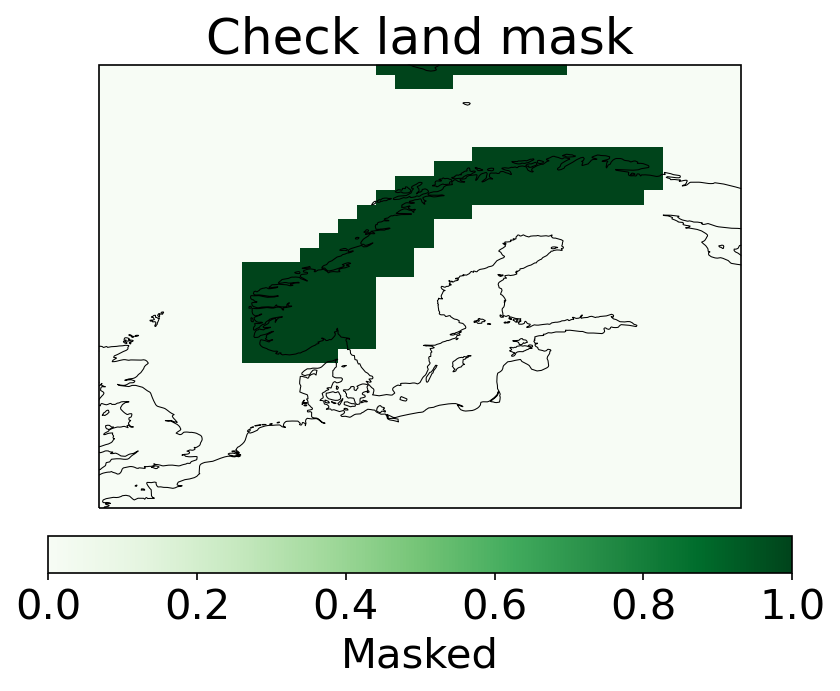

In [14]:
#Check land mask on map plot
fig, axis = plt.subplots(1, 1, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()))
fg = land_mask.plot(cmap='Greens',
    cbar_kwargs={'label': f'Masked','orientation':'horizontal','pad':0.05},
    xlim=(lon_min-5,lon_max+5),
    ylim=(lat_min-5,lat_max+5),
    )

plt.title(f"Check land mask")
axis.coastlines(linewidth=0.5)  # cartopy function
#axis.add_feature(cartopy.feature.OCEAN,facecolor=("aliceblue"))

In [15]:
#mask array, anything not land has data = nan
ensemble_array_m = ensemble_array.where(land_mask)
print('land mask done')

land mask done


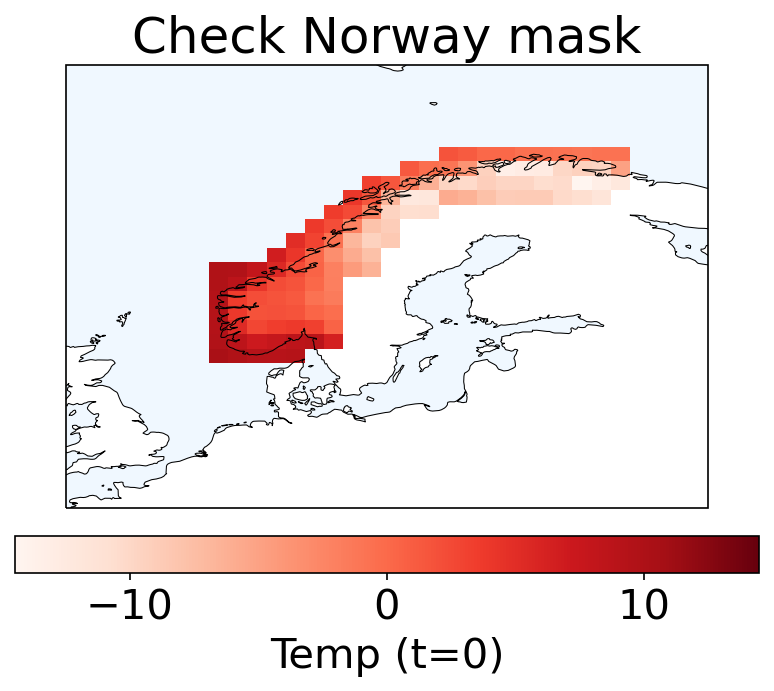

In [16]:
#Check land mask on map plot
fig, axis = plt.subplots(1, 1, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()))
fg = ensemble_array_m['TREFHTMX'].isel(time=0).isel(member=0).plot(cmap='Reds',
    cbar_kwargs={'label': f'Temp (t=0)','orientation':'horizontal','pad':0.05},
    xlim=(lon_min-5,lon_max+5),
    ylim=(lat_min-5,lat_max+5),
    )

plt.title(f"Check Norway mask")
axis.coastlines(linewidth=0.5)  # cartopy function
axis.add_feature(cartopy.feature.OCEAN,facecolor=("aliceblue"))

### Calculate 14day mean and climatology

In [17]:
#calculate 14day mean
ensemble_array_m['temp_14day'] = ensemble_array_m[var_name].rolling(time=14,min_periods=14,center=True).mean(skipna=True)#.mean(dim='member',skipna=True)

In [18]:
#calculate monthly climatology for 2015-2034 period, and anomaly 
ds_climo = ensemble_array_m['temp_14day'].sel(time=slice('2015-01-01','2034-12-31')).groupby('time.month').mean('time').mean(dim='member',skipna=True).to_dataset()
ds_anoms = (ensemble_array_m['temp_14day'].groupby('time.month') - ds_climo)

Text(0.5, 1.0, 'Monthly climatology')

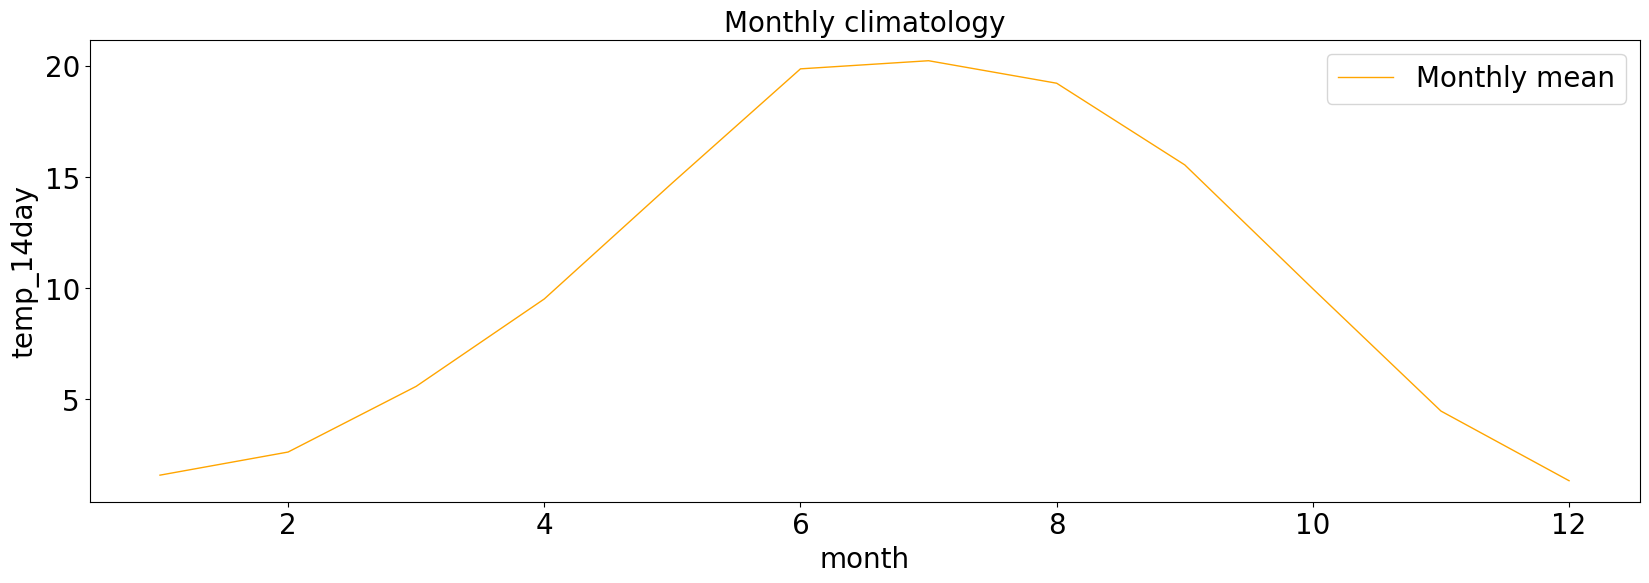

In [19]:
#plot climatology
plt.figure(figsize=(20,6))   # width, height
ds_climo['temp_14day'].sel(lat=59.91273,lon=10.74609,method='nearest').plot(label='Monthly mean',c='orange',linewidth=1,zorder=10)

plt.legend();
plt.title(label="Monthly climatology", fontsize=20)

Text(0.5, 1.0, 'Anomaly wrt climatology')

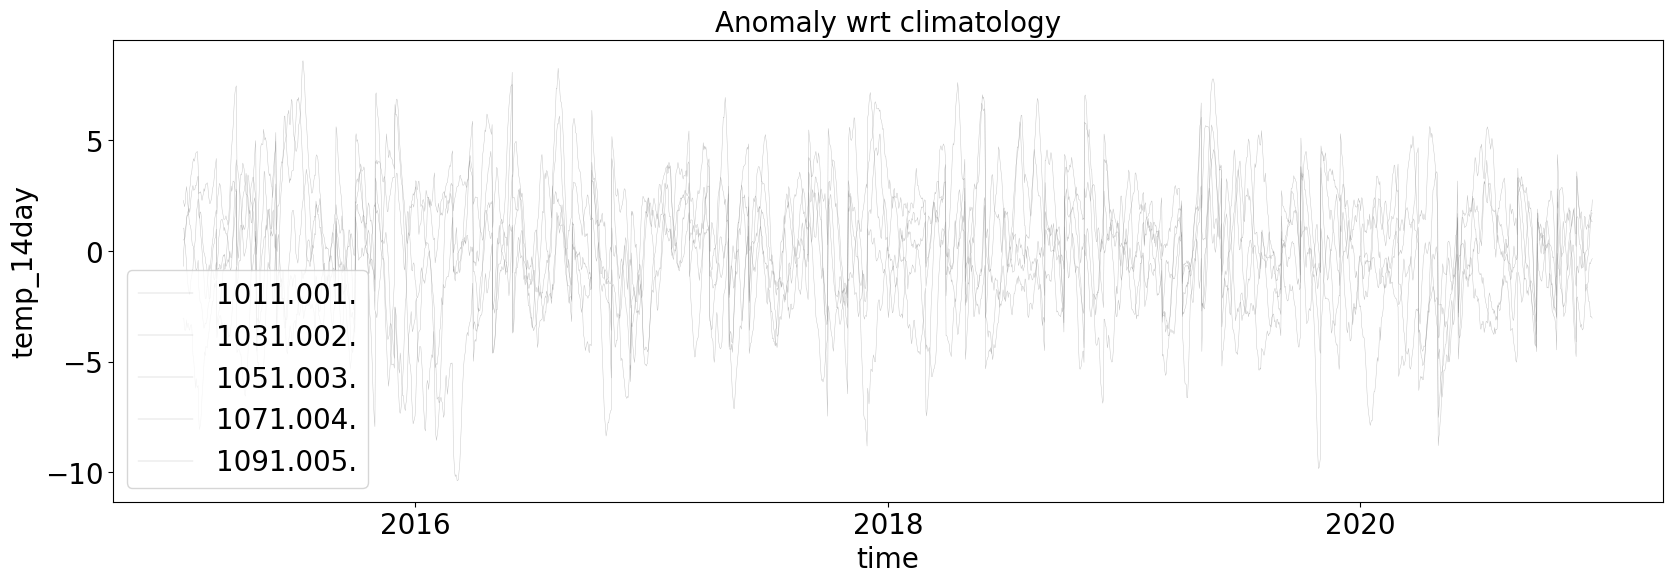

In [20]:
#plot ens members - climatology
plt.figure(figsize=(20,6))   # width, height
for index,en_mem in enumerate(ens_labs[:5]):
    ds_anoms['temp_14day'].sel(member=en_mem).sel(lat=59.91273,lon=10.74609,method='nearest').plot(label = ens_labs[:5][index],linewidth = 0.3,c='grey',alpha=0.5)

plt.legend();
plt.title(label="Anomaly wrt climatology", fontsize=20)

### Calculate sigma levels

In [21]:
#calculate standard deviation
#select climatology period
ds_climo['std_monthly'] = ensemble_array_m['temp_14day'].sel(time=slice('2015-01-01','2034-12-31')).groupby('time.month').std(('member','time'))
ds_climo['sigma_level'] = sigma_level * ds_climo['std_monthly']

In [22]:
## bunch of plotting stuff to look at anomalies vs sigma levels, can be deleted for selection
#make datetime list for monthly whole time period
monthly_climo_datetimes = xr.date_range(start="2015-01-01",end="2020-12-01",freq='MS',use_cftime=True)

#make std monthly dataset
std_monthly_ds = xr.concat([ds_climo.std_monthly]*6,dim='month').to_dataset()
std_monthly_ds['month'] = monthly_climo_datetimes

/div/qbo/users/py3Env/venv_basic/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Climatology of standard deviation')

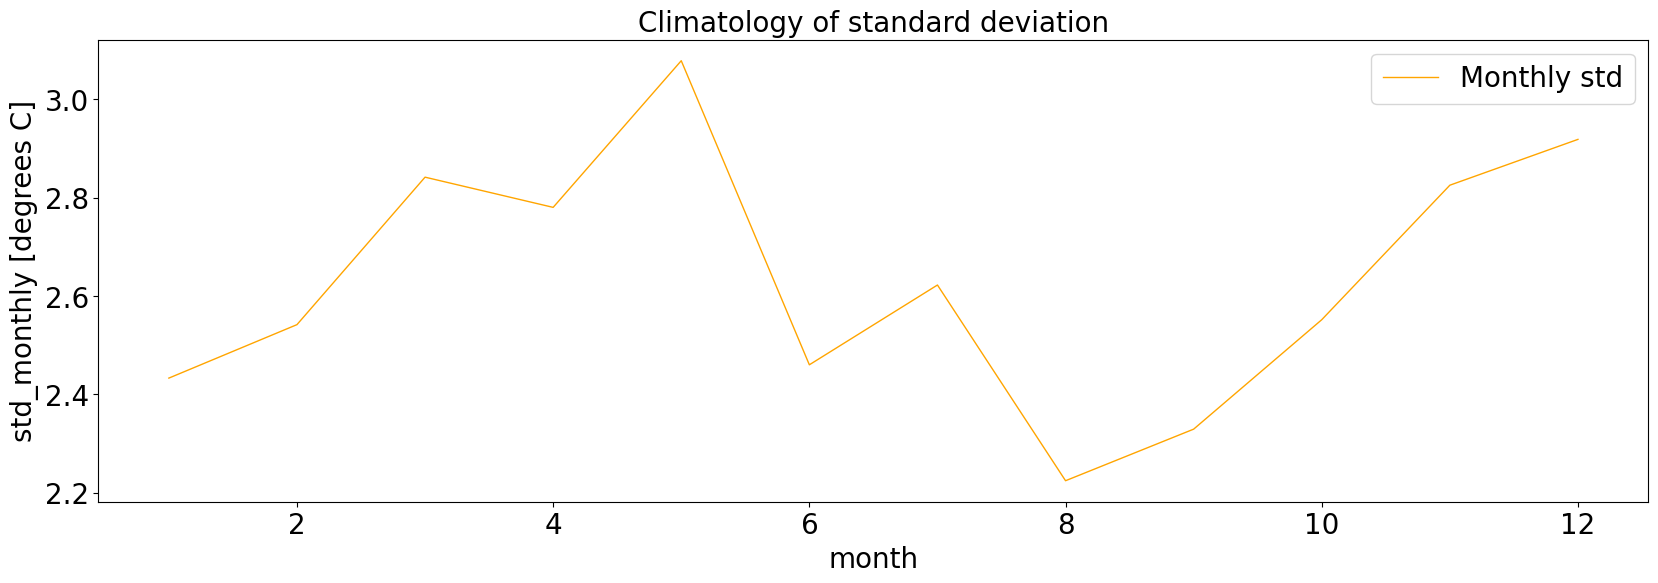

In [23]:
plt.figure(figsize=(20,6))   # width, height
ds_climo['std_monthly'].sel(lat=59.91273,lon=10.74609,method='nearest').plot(label='Monthly std',c='orange',linewidth=1,zorder=10)

plt.legend();
plt.title(label="Climatology of standard deviation", fontsize=20)

/div/qbo/users/py3Env/venv_basic/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/div/qbo/users/py3Env/venv_basic/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/div/qbo/users/py3Env/venv_basic/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Detrended temp + climatology')

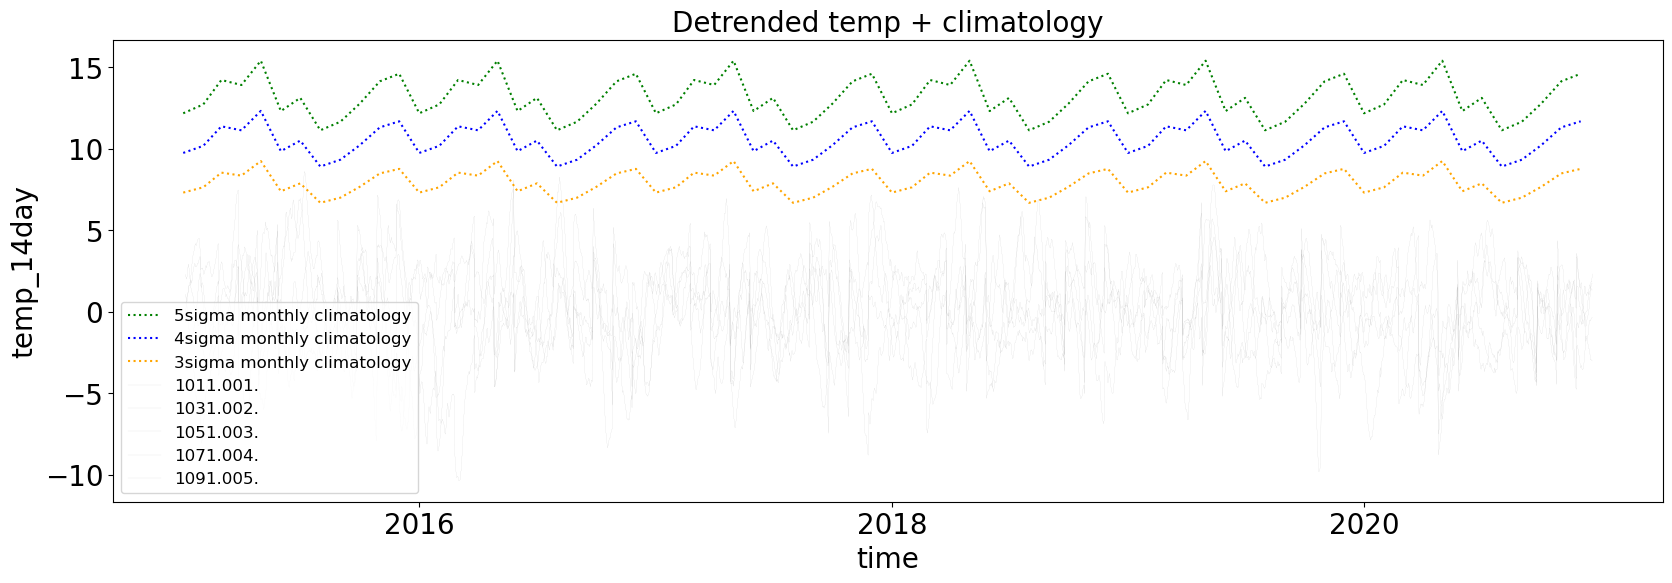

In [24]:
#example plot, anomalies and sigma levels for one location - this is what events are identified based on
plt.figure(figsize=(20,6))   # width, height

(std_monthly_ds['std_monthly'].sel(lat=59.91273,lon=10.74609,method='nearest')*5).plot(label='5sigma monthly climatology',linestyle = ':',c='green',zorder=10)
(std_monthly_ds['std_monthly'].sel(lat=59.91273,lon=10.74609,method='nearest')*4).plot(label='4sigma monthly climatology',linestyle = ':',c='blue',zorder=10)
(std_monthly_ds['std_monthly'].sel(lat=59.91273,lon=10.74609,method='nearest')*3).plot(label='3sigma monthly climatology',linestyle = ':',c='orange',zorder=10)


#plt.axhline(y=(ds_anoms['std'].sel(lat=59.91273,lon=10.74609,method='nearest')*4),label='4sigma anom',linestyle = ':',c='blue',zorder=9)

for index,en_mem in enumerate(ens_labs[:5]):
    ds_anoms['temp_14day'].sel(member=en_mem).sel(lat=59.91273,lon=10.74609,method='nearest').plot(label = ens_labs[:5][index],linewidth = 0.05,c='grey')


#plt.axhline(y=(std_for_plotting*4).sel(lat=59.91273,lon=10.74609,method='nearest'),label='4sigma',linestyle = ':',c='blue')
#plt.axhline(y=(std_for_plotting*5).sel(lat=59.91273,lon=10.74609,method='nearest'),label='5sigma',linestyle = ':',c='pink')
plt.legend(fontsize=12,loc=3)
plt.title(label="Detrended temp + climatology", fontsize=20)

### Find where sigma level exceeded in each gridbox, check whether the extreme persists for >3 days

In [25]:
#subtract sigma level from all data (positive values = above sigma level chosen)
ds_anoms['exceeding_sigma'] = ds_anoms['temp_14day'].groupby('time.month') - ds_climo['sigma_level']

In [26]:
#set threshold for consecutive days/lats/lons
consecutive_days_threshold = 3
grid_threshold = 3
total_sum_threshold = consecutive_days_threshold + grid_threshold*2
threshold_label = f'{consecutive_days_threshold}_{grid_threshold}'

In [27]:
exceed_sigma_boolean = ds_anoms['exceeding_sigma'] > 0

In [28]:
# find where >3days >3lats >3lons condition is met
more_3_days = exceed_sigma_boolean.rolling(time=consecutive_days_threshold,center=True,min_periods=consecutive_days_threshold).sum()
more_3_lons = exceed_sigma_boolean.rolling(lon=grid_threshold,center=True,min_periods=grid_threshold).sum()
more_3_lats = exceed_sigma_boolean.rolling(lat=grid_threshold,center=True,min_periods=grid_threshold).sum()

#more_3_lons_lats_times = exceed_sigma_boolean.rolling({'longitude':grid_threshold,'latitude':grid_threshold,'t':consecutive_days_threshold}, center=True,min_periods=3).sum()

In [29]:
#combine all conditions
all_lats_lons_times = more_3_days + more_3_lons + more_3_lats

#array for where all conditions are met
consecutive_exceed_sigma_all = all_lats_lons_times == total_sum_threshold


### Make array of locs of extreme events

In [30]:
#where gridpoints meet condition
member,time,lat,lon = np.where(consecutive_exceed_sigma_all==True)

/div/qbo/users/py3Env/venv_basic/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [32]:
#make array of extreme locations
where_extreme_array = pd.DataFrame(data = {
    'member_ind': member,
    'time_ind': time,
    'lat_ind': lat,
    'lon_ind':lon,
    'member': [ensemble_array_m.member[member[i]].item() for i in np.arange(len(member))],
    'time': [ensemble_array_m.time[time[i]].item() for i in np.arange(len(member))],
    'lat': [ensemble_array_m.lat[lat[i]].item() for i in np.arange(len(member))],
    'lon': [ensemble_array_m.lon[lon[i]].item() for i in np.arange(len(member))]
})

In [33]:
#save array of lats/lons/members/times
where_extreme_array.to_csv(f'{output_write}/{region_label}_{exp_name}_{var_name}_{sigma_lab}_sigma_{consecutive_days_threshold}days_{grid_threshold}box_locs_14day_test.csv')


In [34]:
#read in array 
where_extreme_array_saved = pd.read_csv(f'{output_write}/{region_label}_{exp_name}_{var_name}_{sigma_lab}_sigma_{consecutive_days_threshold}days_{grid_threshold}box_locs_14day_test.csv',index_col=0)

In [35]:
#function to convert time from array into pandas time in new column
def convert_pandas_time(dataframe):
    dataframe['pd_time'] = pd.to_datetime(dataframe['time'], format='%Y-%m-%d %H:%M:%S',errors='coerce')

#add column with datetime
convert_pandas_time(where_extreme_array_saved)

### Group single day/lat/lon in to events

In [36]:
#function to group days into events (by time and mean over lat lon)
#selects relevant columns in first line
def group_event(extreme_locs_data):
    #group by member and time, mean over lat lon (for events that take place in same member at same time)
    time_member_grouped = extreme_locs_data.iloc[:, np.r_[0,1,2,3,-3,-2,-1]].groupby(by=['member_ind','time_ind'],as_index=False).mean(numeric_only=False)
    
    #boolean array of whether time index is one above the previous one (cumul = False)
    diff_to_previous =  time_member_grouped.time_ind !=  (time_member_grouped.time_ind+1).shift(1)
    #convert boolean to cumulative sum
    cumul_sum = diff_to_previous.cumsum()
    events = time_member_grouped.groupby(cumul_sum,as_index=False).mean(numeric_only=False)
    return events, len(events) #returns array, with time index meaned over consecutive days, and number of events

#group days/gridboxes into events
events_array, events_number = group_event(where_extreme_array_saved)

number_of_events_summary = f'{region_label} {exp_name} {var_name} {sigma_lab} sigma {consecutive_days_threshold} days {grid_threshold} boxes: {events_number}'
print(number_of_events_summary)

with open(f'{output_write}/number_of_events.txt', 'a') as file:
    file.write(f'{number_of_events_summary}\n')

#round time, lat, lon to nearest whole number for indexing
events_array.round({'time_ind': 0, 'lat_ind': 0, 'lon_ind': 0,'lat':2,'lon':2})

#convert to integer for indexing
events_array['time_ind'] = events_array['time_ind'].astype(int)
events_array['lat_ind'] = events_array['lat_ind'].astype(int)
events_array['lon_ind'] = events_array['lon_ind'].astype(int)
events_array['member_ind'] = events_array['member_ind'].astype(int)

#save events array of lats/lons/members/times
events_array.to_csv(f'{output_write}/{region_label}_{exp_name}_{var_name}_{sigma_lab}_sigma_{consecutive_days_threshold}days_{grid_threshold}box_events.csv')

print('events array saved')

NO BSSP370smbb TREFHTMX 2 sigma 3 days 3 boxes: 75
events array saved


### Plots (non land masked data)

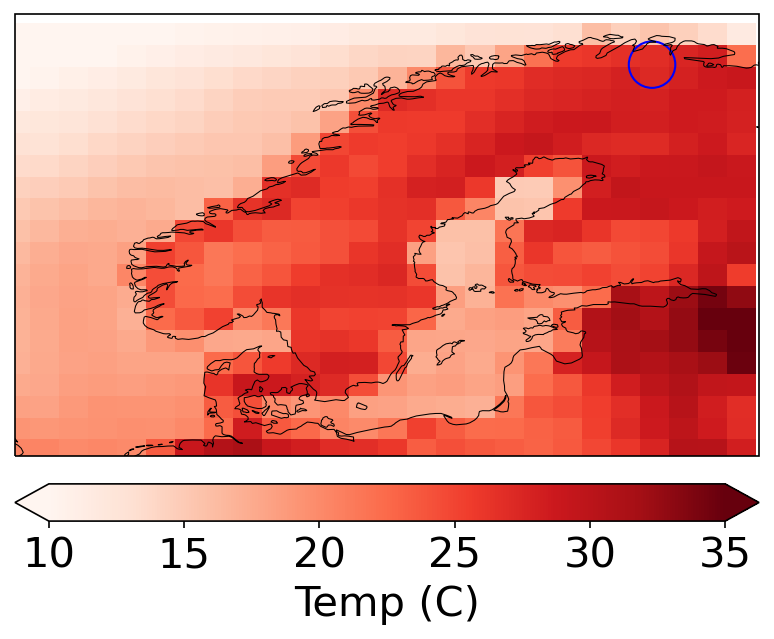

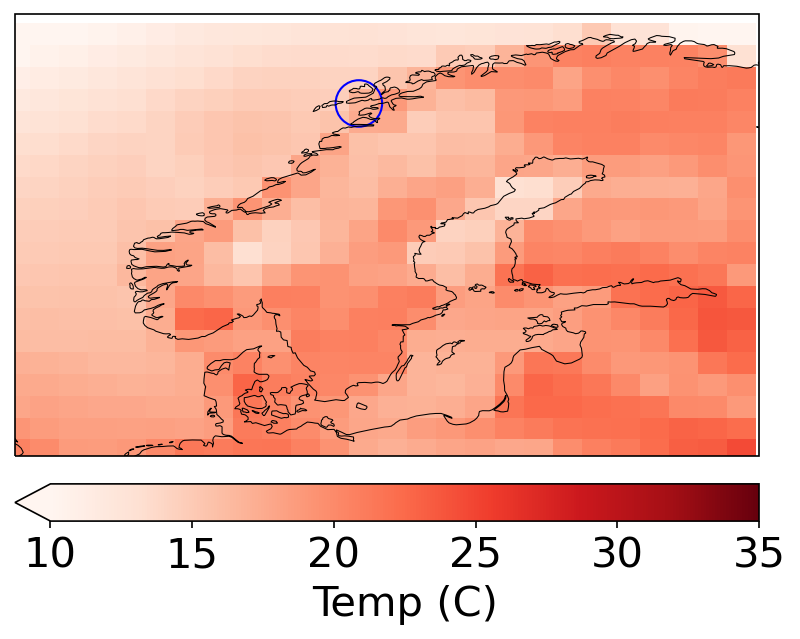

In [37]:
#plot temperature for single day when event occurs, unmasked data
for n,time_ind in enumerate(events_array.time_ind[:2]):
    member_ind = events_array.member_ind[n]
    time_lab = str(events_array.pd_time[n])
    lat_lab=events_array.lat[n].round(2)
    lon_lab=events_array.lon[n].round(2)


    fig, axis = plt.subplots(1, 1, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()))
    fg = ensemble_array['TREFHTMX'].isel(time=time_ind,member=member_ind).plot(cmap='Reds',
                                                                               vmin=10,
                                                                               vmax=35,
                                                                               #add_colorbar=False,
                                                                  cbar_kwargs={'label': f'Temp (C)','orientation':'horizontal','pad':0.05},
                                                                  xlim=(lon_min,lon_max),
                                                                  ylim=(lat_min,lat_max),
    )
    circle2 = plt.Circle((lon_lab, lat_lab), 1, color='blue', fill=False)
    axis.add_patch(circle2)
    plt.title('')
    #plt.title(f'r{member_ind+1} {time_lab}',fontsize=16)
    axis.coastlines(linewidth=0.5)  # cartopy function
    fig.savefig(f'{out_plots}/trefhtmx_14day_{sigma_lab}_r{member_ind+1}_{time_lab[:10]}_{lat_lab}_{lon_lab}_single.png', format='png', bbox_inches='tight')

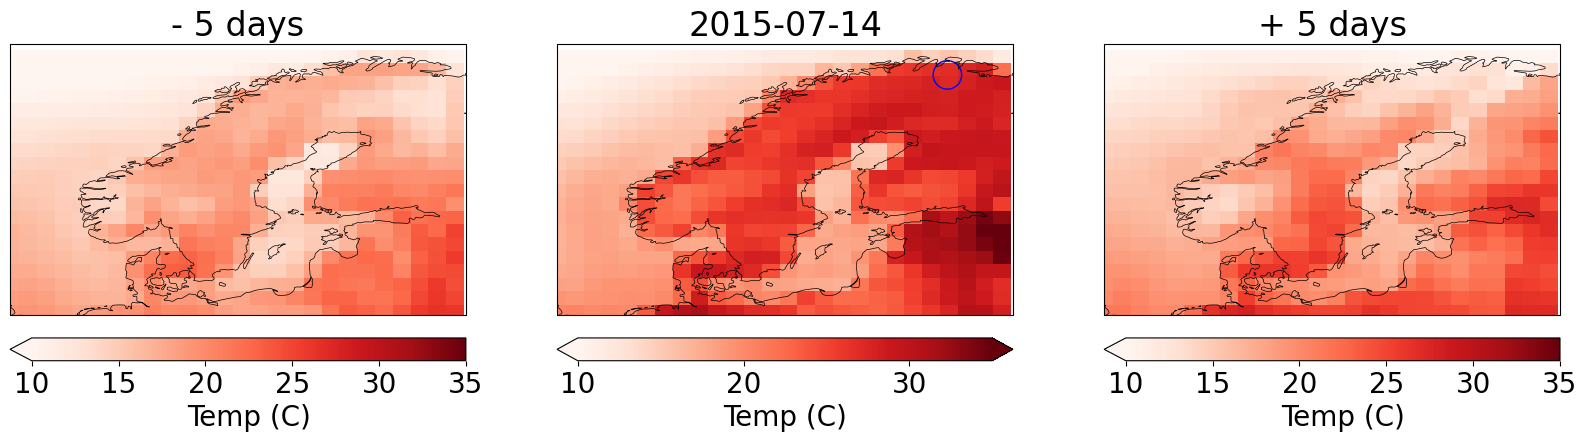

In [38]:
#plot +5 and -5 days around event
for n,time_ind in enumerate(events_array.time_ind[:1]):
    member_ind = events_array.member_ind[n]
    time_lab = str(events_array.pd_time[n])
    lat_lab=events_array.lat[n].round(2)
    lon_lab=events_array.lon[n].round(2)


    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,6), subplot_kw=dict(projection=ccrs.PlateCarree()))
    fg = ensemble_array['TREFHTMX'].isel(time=time_ind - 5,member=member_ind).plot(cmap='Reds',
                                                                               ax=ax1,
                                                                               vmin=10,
                                                                               vmax=35,
                                                                               #add_colorbar=False,
                                                                  cbar_kwargs={'label': f'Temp (C)','orientation':'horizontal','pad':0.05},
                                                                  xlim=(lon_min,lon_max),
                                                                  ylim=(lat_min,lat_max),
    )
    ax1.coastlines(linewidth=0.5)
    ax1.set_title(f'- 5 days')
    fg = ensemble_array['TREFHTMX'].isel(time=time_ind,member=member_ind).plot(cmap='Reds',
                                                                               ax=ax2,
                                                                               vmin=10,
                                                                               vmax=35,
                                                                               #add_colorbar=False,
                                                                  cbar_kwargs={'label': f'Temp (C)','orientation':'horizontal','pad':0.05},
                                                                  xlim=(lon_min,lon_max),
                                                                  ylim=(lat_min,lat_max),
    )
    ax2.coastlines(linewidth=0.5)
    ax2.set_title(f'{time_lab[:10]}')
    circle2 = plt.Circle((lon_lab, lat_lab), 1, color='blue', fill=False)
    ax2.add_patch(circle2)

    fg = ensemble_array['TREFHTMX'].isel(time=time_ind+5,member=member_ind).plot(cmap='Reds',
                                                                               ax=ax3,
                                                                               vmin=10,
                                                                               vmax=35,
                                                                               #add_colorbar=False,
                                                                  cbar_kwargs={'label': f'Temp (C)','orientation':'horizontal','pad':0.05},
                                                                  xlim=(lon_min,lon_max),
                                                                  ylim=(lat_min,lat_max),
    )
    ax3.coastlines(linewidth=0.5)
    ax3.set_title(f'+ 5 days')


    #plt.title('')
    #plt.title(f'r{member_ind+1} {time_lab}',fontsize=16)
    #axis.coastlines(linewidth=0.5)  # cartopy function
    fig.savefig(f'{out_plots}/trefhtmx14_{sigma_lab}_r{member_ind+1}_{time_lab[:10]}_{lat_lab}_{lon_lab}_plusmin5.png', format='png', bbox_inches='tight')